# Initial Setup

In [ ]:
# 1. Mount Google Drive

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 2. Define root directory

ROOT_DIR = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab'

In [ ]:
# 3. Install Ultralytics

!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00


# First Training

In [ ]:
# 4. Train model

import os

from ultralytics import YOLO


# Cargar model
model = YOLO("yolov8n-seg.pt")

# Entrenar model
results = model.train(data=os.path.join(ROOT_DIR, "google_colab_config.yaml"),
                      epochs=50,
                      imgsz=800,
                      batch=8,
                      patience=50)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/google_colab_config.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fal

In [ ]:
# 5. Copy results

!scp -r /content/runs '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab'

In [ ]:
# 6. Get clean results

import os
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image

# Load trained model
model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

# Path to validation images
val_dir = os.path.join(ROOT_DIR, "data/images/val")

# Run prediction
results = model.predict(source=val_dir, save=False, retina_masks=True)

# Pick one result
result = results[2]

# Get original image
img = result.orig_img.copy()
h, w = img.shape[:2]

# Optional: if segmentation masks exist
if result.masks is not None:
    for mask_tensor, conf in zip(result.masks.data, result.boxes.conf):
        mask = mask_tensor.cpu().numpy()   # should be H x W (same as img)
        color = (0, 0, 255) if float(conf) < 0.7 else (0, 255, 0)
        colored_mask = np.zeros_like(img, dtype=np.uint8)
        colored_mask[mask > 0.5] = color
        img = cv2.addWeighted(img, 1.0, colored_mask, 0.4, 0)

# Save result
out_path = os.path.join(ROOT_DIR, "val_batch0_pred_confidence_colored_03.jpg")
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).save(out_path)

print(f"Saved image with confidence-based coloring to {out_path}")

# Background Substraction

(np.float64(-0.5), np.float64(2559.5), np.float64(1439.5), np.float64(-0.5))

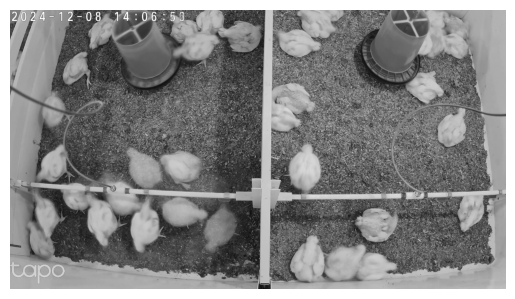

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

video = cv2.VideoCapture(os.path.join(ROOT_DIR, "stitched_output.mp4"))

frames_list = []
max_frames = 200

for i in range(max_frames):
    ok, frame = video.read()
    if not ok:
        break

    # Convertir imatge a escala de grisos.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames_list.append(gray)

video.release()

# Convertir llista a array NumPy (uint8)
frames_array = np.stack(frames_list, axis=0)

fons_estimacio = np.mean(frames_array, axis=0)
#fons_estimacio = np.median(frames_array, axis=0)

# Mostrar el fons final
plt.imshow(fons_estimacio, cmap='gray')
plt.axis('off')

In [ ]:
# Install dependencies
!pip install opencv-python-headless matplotlib

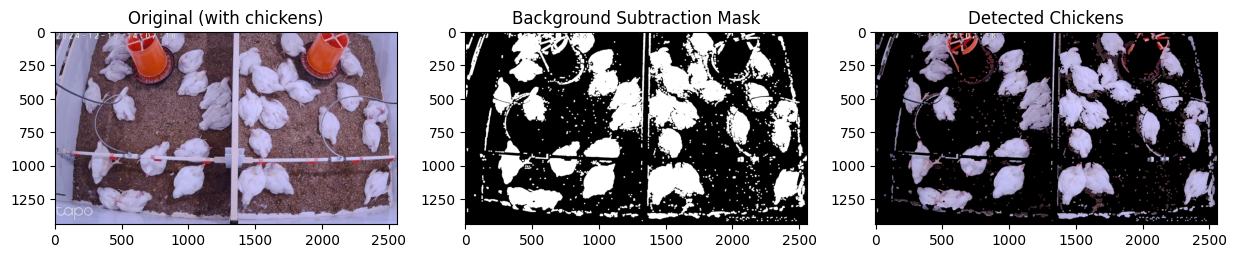

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Get the filenames
chicken_img_path = os.path.join(ROOT_DIR, "data/images/val/frame_000030.jpg")
background_img_path = os.path.join(ROOT_DIR, "RemovedChickens.png")

# Read the images
img_chickens = cv2.imread(chicken_img_path)
img_background = cv2.imread(background_img_path)

# Resize both to same size if needed
if img_chickens.shape != img_background.shape:
    img_background = cv2.resize(img_background, (img_chickens.shape[1], img_chickens.shape[0]))

# Convert to grayscale
gray_chickens = cv2.cvtColor(img_chickens, cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2GRAY)

# Background subtraction
diff = cv2.absdiff(gray_chickens, gray_background)

# Threshold the difference
_, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

# Morphological operations to clean up noise
kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_DILATE, kernel)

# Apply mask on the original image
result = cv2.bitwise_and(img_chickens, img_chickens, mask=mask_clean)

# Display results
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.title("Original (with chickens)")
plt.imshow(cv2.cvtColor(img_chickens, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.title("Background Subtraction Mask")
plt.imshow(mask_clean, cmap='gray')

plt.subplot(1,3,3)
plt.title("Detected Chickens")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

# Norfair

In [ ]:
!pip install norfair[video] 'git+https://github.com/facebookresearch/detectron2.git' opencv-python-headless==4.8.0.74

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-nu0s_s1k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-nu0s_s1k
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
Reason for being yanked: deprecated, use 4.8.0.76
   ━━━━━━━━━━━━━━

In [ ]:
#Norfair try 2 # ~4 frames por segundo

import cv2
import torch
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from norfair import Detection, Tracker, Video, draw_tracked_objects
from ultralytics import YOLO
import os

# Define paths
VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output.mp4'

# Initialize model
model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))
results = model.predict(VIDEO_PATH, stream=True)

# Initialize Norfair tracker
tracker = Tracker(distance_function="euclidean", distance_threshold=30)

# Prepare video reader/writer
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Process frames one by one
frame_idx = 0
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy().astype(int)

    TARGET_CLASSES = []
    if TARGET_CLASSES:
        mask = np.isin(classes, TARGET_CLASSES)
        boxes, confs = boxes[mask], confs[mask]

    # Convert detections to Norfair format
    detections = [
        Detection(np.array([[b[0], b[1]]]), scores=np.array([c]))
        for b, c in zip(boxes, confs)
    ]

    # Update tracker
    tracked_objects = tracker.update(detections=detections)

    # Draw tracked objects on the frame
    draw_tracked_objects(frame, tracked_objects)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"Tracking complete! Saved to: {OUTPUT_PATH}")


video 1/1 (frame 1/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 309.7ms
video 1/1 (frame 2/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 193.8ms
video 1/1 (frame 3/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 182.4ms
video 1/1 (frame 4/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 192.3ms
video 1/1 (frame 5/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 193.4ms
video 1/1 (frame 6/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 196.1ms
video 1/1 (frame 7/3000) /content/gdrive/My Drive/ComputerVisio

# Deep-Sort

In [ ]:
!pip install deep-sort-realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.1 MB/s eta 0:00:00


In [ ]:
#DeepSort tracking algorithm

import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

# Paths
VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_deepsort2.mp4'

# Load YOLOv8 Model
model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

# Initialize DeepSort
tracker = DeepSort(
    max_age=30,
    n_init=3,
    nn_budget=100,
    max_cosine_distance=0.3,
    embedder="mobilenet",
    half=True
)

# Video I/O
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Tracking Loop
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img

    if result.masks is not None:
        polygons = result.masks.xy
        boxes_xyxy = []

        for poly in polygons:
            poly = np.array(poly)
            x_min, y_min = poly[:,0].min(), poly[:,1].min()
            x_max, y_max = poly[:,0].max(), poly[:,1].max()
            boxes_xyxy.append([x_min, y_min, x_max, y_max])

        boxes_xyxy = np.array(boxes_xyxy)
    else:
        boxes_xyxy = result.boxes.xyxy.cpu().numpy()

    confs = result.boxes.conf.cpu().numpy()
    clss = result.boxes.cls.cpu().numpy()

    detections = []
    for box, conf, cls in zip(boxes_xyxy, confs, clss):
        x1, y1, x2, y2 = box
        detections.append([[x1, y1, x2, y2], conf, int(cls)])

    # DeepSort update
    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw results
    for t in tracks:
        if not t.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, t.to_ltrb())
        track_id = t.track_id

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, f"ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    out.write(frame)

cap.release()
out.release()
print("Tracking complete! Saved to:", OUTPUT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

video 1/1 (frame 1/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 391.2ms
video 1/1 (frame 2/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 261.5ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 259.5ms
video 1/1 (frame 4/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 421.0ms
video 1/1 (frame 5/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetect

In [ ]:
#DeepSort tracking algorithm V2

import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

# Paths
VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_deepsort2.mp4'

# Load YOLOv8 Model
model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

# Initialize DeepSort
tracker = DeepSort(
    max_age=30,
    n_init=3,
    nn_budget=100,
    max_cosine_distance=0.3,
    embedder="mobilenet",
    half=True
)

# Video I/O
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Tracking Loop
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    detections = []

    if result.masks is not None:
        polygons = result.masks.xy
        boxes_xyxy = []

        for poly in polygons:
            poly = np.array(poly)
            x_min, y_min = poly[:,0].min(), poly[:,1].min()
            x_max, y_max = poly[:,0].max(), poly[:,1].max()
            boxes_xyxy.append([x_min, y_min, x_max, y_max])

        boxes_xyxy = np.array(boxes_xyxy)
    else:
        boxes_xyxy = result.boxes.xyxy.cpu().numpy()

    confs = result.boxes.conf.cpu().numpy()
    clss = result.boxes.cls.cpu().numpy()

    for box, conf, cls in zip(boxes_xyxy, confs, clss):
        if conf < 0.7:
            continue
        x1, y1, x2, y2 = box

        w = x2 - x1
        h = y2 - y1
        tlwh = [x1, y1, w, h]

        detections.append([tlwh, conf, int(cls)])

    # DeepSort update
    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw results
    for t in tracks:
        if not t.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, t.to_ltrb())
        track_id = t.track_id

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, f"ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    out.write(frame)

cap.release()
out.release()
print("Tracking complete! Saved to:", OUTPUT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

video 1/1 (frame 1/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 560.4ms
video 1/1 (frame 2/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 290.9ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 281.7ms
video 1/1 (frame 4/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 294.2ms
video 1/1 (frame 5/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetect

In [ ]:
#DeepSort for Comparison (MOT)

import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

# Paths
VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_deepsortComparison.mp4'

# Load YOLOv8 Model
model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

# Initialize DeepSort
tracker = DeepSort(
    max_age=30,
    n_init=3,
    nn_budget=100,
    max_cosine_distance=0.3,
    embedder="mobilenet",
    half=True
)

# Video I/O
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Tracking Loop
mot_results = []
frame_id = 1
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    detections = []

    if result.masks is not None:
        polygons = result.masks.xy
        boxes_xyxy = []

        for poly in polygons:
            poly = np.array(poly)
            x_min, y_min = poly[:,0].min(), poly[:,1].min()
            x_max, y_max = poly[:,0].max(), poly[:,1].max()
            boxes_xyxy.append([x_min, y_min, x_max, y_max])

        boxes_xyxy = np.array(boxes_xyxy)
    else:
        boxes_xyxy = result.boxes.xyxy.cpu().numpy()

    confs = result.boxes.conf.cpu().numpy()
    clss = result.boxes.cls.cpu().numpy()

    for box, conf, cls in zip(boxes_xyxy, confs, clss):
        if conf < 0.7:
            continue
        x1, y1, x2, y2 = box

        w = x2 - x1
        h = y2 - y1
        tlwh = [x1, y1, w, h]

        detections.append([tlwh, conf, int(cls)])

    # DeepSort update
    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw results
    for t in tracks:
        if not t.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, t.to_ltrb())
        w, h = x2 - x1, y2 - y1
        track_id = t.track_id
        mot_results.append(
            f"{frame_id},{t.track_id},{x1},{y1},{w},{h},1,-1,-1\n"
        )

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, f"ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    frame_id += 1
    out.write(frame)

with open("deepsort.txt", "w") as f:
    f.writelines(mot_results)
cap.release()
out.release()
print("Tracking complete! Saved to:", OUTPUT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

video 1/1 (frame 1/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 34 Chickens, 369.2ms
video 1/1 (frame 2/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 273.7ms
video 1/1 (frame 3/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 253.0ms
video 1/1 (frame 4/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 381.4ms
video 1/1 (frame 5/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetect

# Norfair + HoG

In [ ]:
!pip install norfair[video] opencv-python-headless==4.8.0.74

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
Reason for being yanked: deprecated, use 4.8.0.76
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=28d99af4d28de9f085362d31a807adc0ceb620d77ec4a243108898ad8d862be1
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built fil

In [ ]:
#Norfair try with HoG ReIdentification

import cv2
import torch
import numpy as np
from norfair import Detection, Tracker, Video, draw_tracked_objects
from ultralytics import YOLO
import os

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hog2.mp4'

hog = cv2.HOGDescriptor(
    _winSize=(64, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9,
)

def hog_distance(detection, tracked_object):
    det_center = detection.points[0]
    track_center = tracked_object.estimate[0]
    pos_dist = np.linalg.norm(det_center - track_center)

    det_hog = detection.embedding
    track_hog = tracked_object.last_detection.embedding
    hog_dist = np.linalg.norm(det_hog - track_hog)

    return pos_dist * 0.3 + hog_dist * 0.7

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))
results = model.predict(VIDEO_PATH, stream=True)

tracker = Tracker(distance_function=hog_distance, distance_threshold=30)

# Prepare video reader/writer
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Process frames one by one
frame_idx = 0
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy().astype(int)

    # Filter detections by confidence
    CONF_THRESH = 0.7
    mask = confs >= CONF_THRESH
    boxes, confs, classes = boxes[mask], confs[mask], classes[mask]

    TARGET_CLASSES = []
    if TARGET_CLASSES:
        class_mask = np.isin(classes, TARGET_CLASSES)
        boxes, confs = boxes[class_mask], confs[class_mask]

    # Convert detections to Norfair format
    detections = []
    for b, c in zip(boxes, confs):
        x, y, w, h = map(int, b)

        x1 = max(x - w//2, 0)
        y1 = max(y - h//2, 0)
        x2 = min(x + w//2, width)
        y2 = min(y + h//2, height)
        crop = frame[y1:y2, x1:x2]

        crop_resized = cv2.resize(crop, (64, 128))
        hog_feat = hog.compute(crop_resized).reshape(-1)

        detections.append(
            Detection(
                points=np.array([[x, y]]),
                scores=np.array([c]),
                embedding=hog_feat
            )
        )

    # Update tracker
    tracked_objects = tracker.update(detections=detections)

    # Draw tracked objects on the frame
    draw_tracked_objects(frame, tracked_objects)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"Tracking complete! Saved to: {OUTPUT_PATH}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



video 1/1 (frame 1/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 1073.6ms


video 1/1 (frame 2/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 548.3ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 465.3ms
video 1/1 (frame 4/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 465.6ms
video 1/1 (frame 5/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 409.9ms
video 1/1 (frame 6/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 498.5ms
video 1/1 (frame 7/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 35 Chickens, 516.7ms
video 1/1 (frame 8/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8G

In [ ]:
#Norfair try with HoG ReIdentification for Comparison (MOT)

import cv2
import torch
import numpy as np
from norfair import Detection, Tracker, Video, draw_tracked_objects
from ultralytics import YOLO
import os

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hogComparison.mp4'

hog = cv2.HOGDescriptor(
    _winSize=(64, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9,
)

def hog_distance(detection, tracked_object):
    det_center = detection.points[0]
    track_center = tracked_object.estimate[0]
    pos_dist = np.linalg.norm(det_center - track_center)

    det_hog = detection.embedding
    track_hog = tracked_object.last_detection.embedding
    hog_dist = np.linalg.norm(det_hog - track_hog)

    return pos_dist * 0.3 + hog_dist * 0.7

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))
results = model.predict(VIDEO_PATH, stream=True)

tracker = Tracker(distance_function=hog_distance, distance_threshold=30)

# Prepare video reader/writer
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Process frames one by one
mot_results = []
frame_id = 1
frame_idx = 0
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy().astype(int)

    # Filter detections by confidence
    CONF_THRESH = 0.7
    mask = confs >= CONF_THRESH
    boxes, confs, classes = boxes[mask], confs[mask], classes[mask]

    TARGET_CLASSES = []
    if TARGET_CLASSES:
        class_mask = np.isin(classes, TARGET_CLASSES)
        boxes, confs = boxes[class_mask], confs[class_mask]

    # Convert detections to Norfair format
    detections = []
    for b, c in zip(boxes, confs):
        x, y, w, h = map(int, b)

        x1 = max(x - w//2, 0)
        y1 = max(y - h//2, 0)
        x2 = min(x + w//2, width)
        y2 = min(y + h//2, height)
        crop = frame[y1:y2, x1:x2]

        crop_resized = cv2.resize(crop, (64, 128))
        hog_feat = hog.compute(crop_resized).reshape(-1)

        detections.append(
            Detection(
                points=np.array([[x, y]]),
                scores=np.array([c]),
                embedding=hog_feat,
                data={"w": w, "h": h}
            )
        )

    # Update tracker
    tracked_objects = tracker.update(detections=detections)

    for obj in tracked_objects:
        if obj.last_detection is None:
            continue

        # Center point
        x, y = obj.estimate[0]

        # Box size from last detection
        w = obj.last_detection.data["w"]
        h = obj.last_detection.data["h"]

        x1 = int(x - w / 2)
        y1 = int(y - h / 2)

        mot_results.append(
            f"{frame_id},{obj.id},{x1},{y1},{w},{h},1,-1,-1\n"
        )

    # Draw tracked objects on the frame
    draw_tracked_objects(frame, tracked_objects)

    out.write(frame)
    frame_id += 1
    frame_idx += 1

with open("norfair_hog.txt", "w") as f:
    f.writelines(mot_results)
cap.release()
out.release()
print(f"Tracking complete! Saved to: {OUTPUT_PATH}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



video 1/1 (frame 1/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 34 Chickens, 418.8ms


video 1/1 (frame 2/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 184.8ms
video 1/1 (frame 3/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 183.4ms
video 1/1 (frame 4/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 186.3ms
video 1/1 (frame 5/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 180.0ms
video 1/1 (frame 6/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 175.6ms
video 1/1 (frame 7/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 35 Chickens, 184.0ms
video 1/1 (frame 8/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8G

# Blobs & Watershed

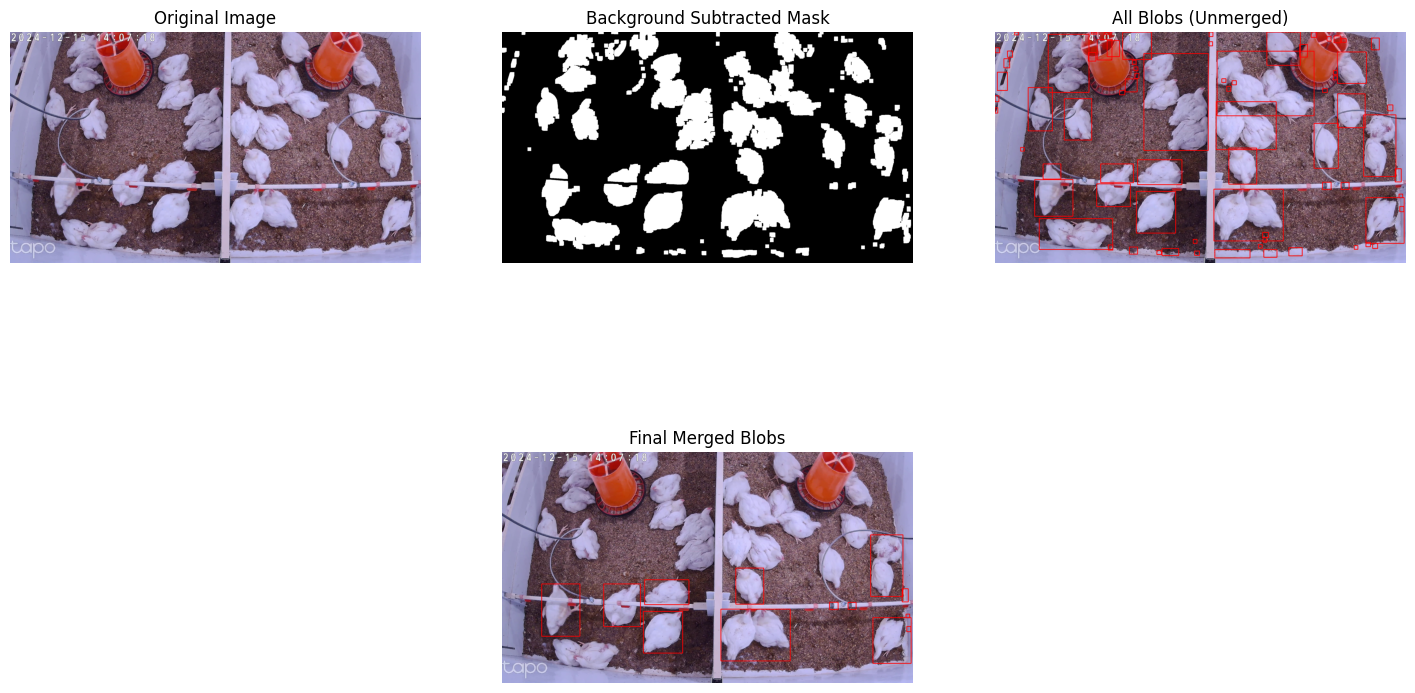

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

chicken_img_path = os.path.join(ROOT_DIR, "data/images/val/frame_000030.jpg")
background_img_path = os.path.join(ROOT_DIR, "RemovedChickens.png")

img_chickens = cv2.imread(chicken_img_path)
img_background = cv2.imread(background_img_path)

# Resize
if img_chickens.shape != img_background.shape:
    img_background = cv2.resize(img_background, (img_chickens.shape[1], img_chickens.shape[0]))

# Convert to grayscale
gray_chickens = cv2.cvtColor(img_chickens, cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2GRAY)

# Background subtraction
diff = cv2.absdiff(gray_chickens, gray_background)

# Threshold
_, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

# Cleanup (Morphology)
kernel = np.ones((12,12), np.uint8)
mask_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_DILATE, kernel)

# Blob Detection

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean) #**Mirar si pot retornar contorns**#

# Empty image for drawing
mask_blobs = np.zeros_like(mask_clean)

H = mask_clean.shape[0]

#Only merging in the 4th fifth

y_min = int(3/5 * H)
y_max = int(4/5 * H)

selected_boxes = []

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]

    # Filter out noise
    if area < 200:
        continue

    blob_top = y
    blob_bottom = y + h

    # Keep blob if it overlaps the correct height
    if blob_bottom >= y_min and blob_top <= y_max:
        selected_boxes.append((x, y, w, h))

# Merging Blobs

def merge_boxes(boxes):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[0])
    merged = [boxes[0]]

    for b in boxes[1:]:
        x, y, w, h = b
        last = merged[-1]
        lx, ly, lw, lh = last

        horizontal_close = x <= lx + lw + 2
        vertical_overlap = not (y > ly + lh + 20 or (y + h) < ly - 20)

        if horizontal_close and vertical_overlap:
            new_x = min(x, lx)
            new_y = min(y, ly)
            new_w = max(x+w, lx+lw) - new_x
            new_h = max(y+h, ly+lh) - new_y
            merged[-1] = (new_x, new_y, new_w, new_h)
        else:
            merged.append(b)
    return merged

merged_boxes = merge_boxes(selected_boxes)

# Visual output
output = img_chickens.copy()
for (x, y, w, h) in merged_boxes:
    cv2.rectangle(output, (x,y), (x+w, y+h), (0,0,255), 3)

all_blobs_img = img_chickens.copy()
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if area < 200:
        continue
    cv2.rectangle(all_blobs_img, (x, y), (x+w, y+h), (0,0,255), 3)

# Display results

plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_chickens, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Background Subtracted Mask")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("All Blobs (Unmerged)")
plt.imshow(cv2.cvtColor(all_blobs_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,3,5)
plt.title("Final Merged Blobs")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

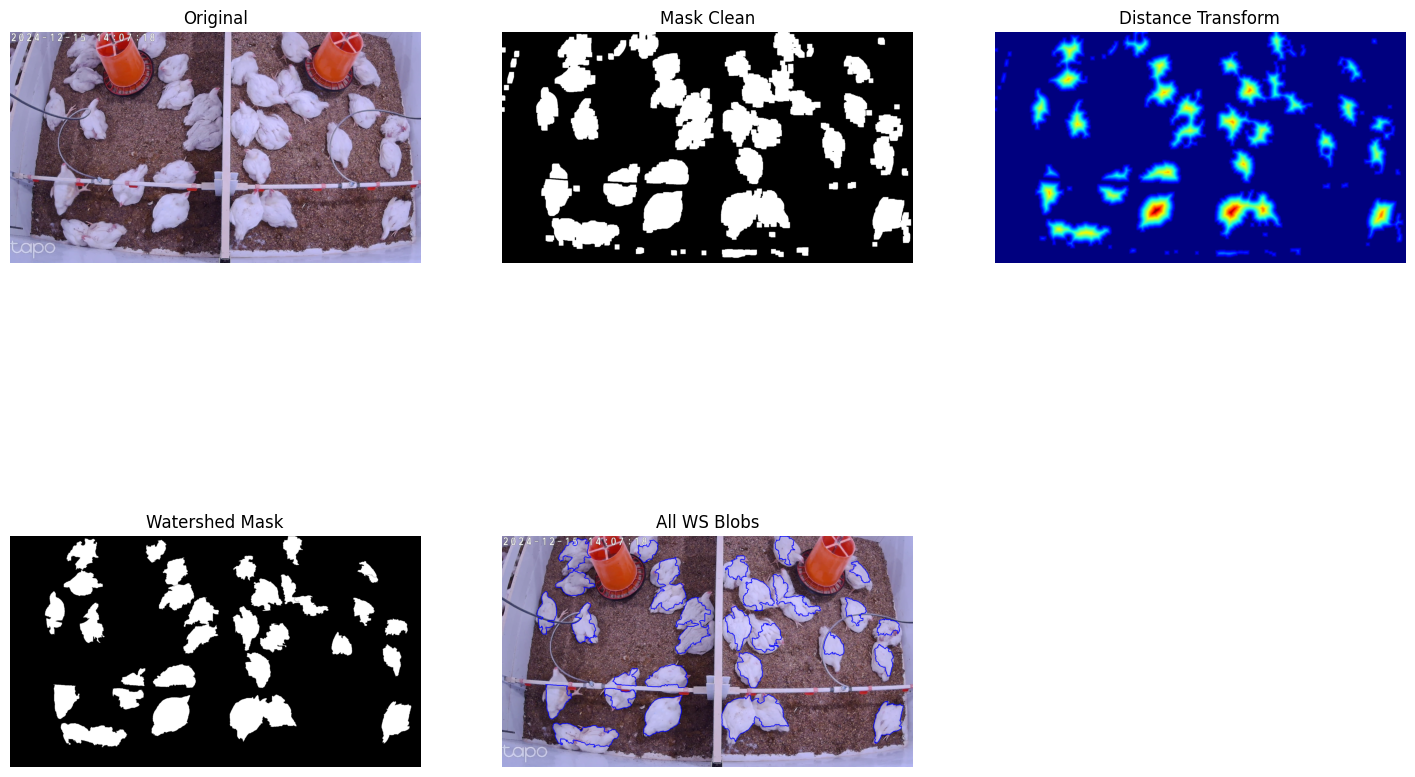

In [ ]:
#Blobs with Watershed

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

chicken_img_path = os.path.join(ROOT_DIR, "data/images/val/frame_000030.jpg")
background_img_path = os.path.join(ROOT_DIR, "RemovedChickens.png")

img_chickens = cv2.imread(chicken_img_path)
img_background = cv2.imread(background_img_path)

# Resize
if img_chickens.shape != img_background.shape:
    img_background = cv2.resize(img_background, (img_chickens.shape[1], img_chickens.shape[0]))

# Convert to grayscale
gray_chickens = cv2.cvtColor(img_chickens, cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2GRAY)

# Background subtraction
diff = cv2.absdiff(gray_chickens, gray_background)

# Threshold
_, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

# Cleanup (Morphology)
kernel = np.ones((15,15), np.uint8)
mask_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_DILATE, kernel)

# Watershed

kernel_small = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel_small, iterations=1)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dt_norm = cv2.normalize(dist_transform, None, 0, 1.0, cv2.NORM_MINMAX)

# Detect maximum point
local_max = (dt_norm > 0.35)
local_max = local_max.astype(np.uint8) * 255

# Clean peaks
local_max = cv2.morphologyEx(local_max, cv2.MORPH_OPEN, kernel_small, iterations=1)

# Connected components on peaks
_, markers = cv2.connectedComponents(local_max)

# Mark background as 1
markers = markers + 1

unknown = cv2.subtract(opening, local_max)
markers[unknown == 255] = 0

# Apply watershed
ws_image = img_chickens.copy()
markers = cv2.watershed(ws_image, markers)

# Watershed boundaries
ws_boundaries = img_chickens.copy()
ws_boundaries[markers == -1] = [0, 255, 0]

# Generate final mask
ws_mask = np.zeros_like(mask_clean)
ws_mask[markers > 1] = 255

# Blob Detection

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(ws_mask)

# Empty image for drawing
H = ws_mask.shape[0]
y_min = int(3/5 * H)
y_max = int(4/5 * H)

selected_boxes = []

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]

    if area < 200:
        continue

    blob_top = y
    blob_bottom = y + h

    if blob_bottom >= y_min and blob_top <= y_max:
        selected_boxes.append((x, y, w, h))

# Merging Blobs

def merge_boxes(boxes):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[0])
    merged = [boxes[0]]

    for b in boxes[1:]:
        x, y, w, h = b
        lx, ly, lw, lh = merged[-1]

        horizontal_close = x <= lx + lw + 2
        vertical_overlap = not (y > ly + lh + 20 or (y + h) < ly - 20)

        if horizontal_close and vertical_overlap:
            new_x = min(x, lx)
            new_y = min(y, ly)
            new_w = max(x+w, lx+lw) - new_x
            new_h = max(y+h, ly+lh) - new_y
            merged[-1] = (new_x, new_y, new_w, new_h)
        else:
            merged.append(b)
    return merged

merged_boxes = merge_boxes(selected_boxes)

# Draw Contours

# Find contours
contours, hierarchy = cv2.findContours(ws_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter small contours
filtered_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area >= 200:
        filtered_contours.append(cnt)

all_ws_blob_img = img_chickens.copy()
cv2.drawContours(all_ws_blob_img, filtered_contours, -1, (255, 0, 0), 3)

# For merged blobs display
merged_contours = []
for (x, y, w, h) in merged_boxes:
    region_mask = np.zeros_like(ws_mask)
    region_mask[y:y+h, x:x+w] = ws_mask[y:y+h, x:x+w]

    cnts, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) >= 200:
            merged_contours.append(c)

output_ws = img_chickens.copy()
cv2.drawContours(output_ws, merged_contours, -1, (0, 0, 255), 3)

# Display

plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_chickens, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Mask Clean")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("Distance Transform")
plt.imshow(dist_transform, cmap='jet')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("Watershed Mask")
plt.imshow(ws_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("All WS Blobs")
plt.imshow(cv2.cvtColor(all_ws_blob_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

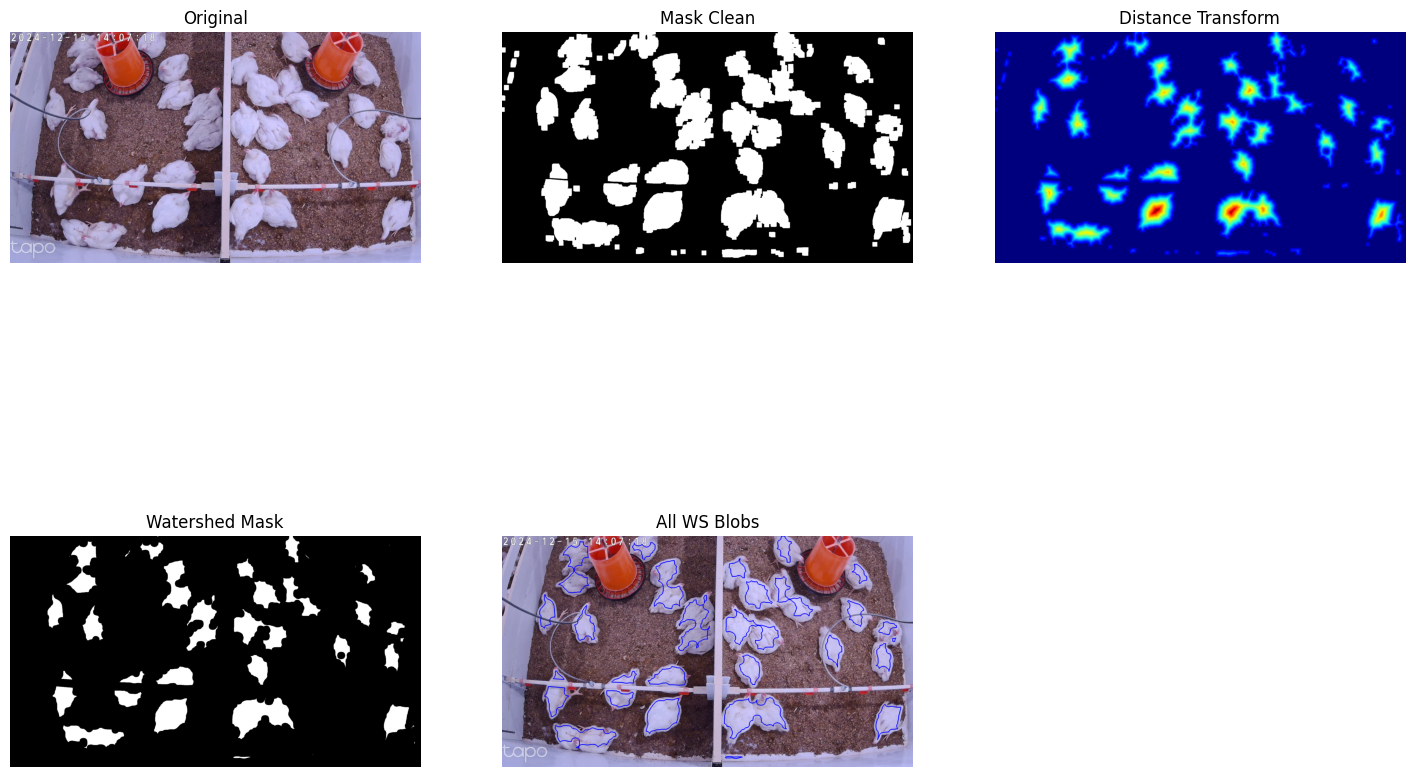

In [ ]:
#Blobs with Watershed (Extra Fix)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

chicken_img_path = os.path.join(ROOT_DIR, "data/images/val/frame_000030.jpg")
background_img_path = os.path.join(ROOT_DIR, "RemovedChickens.png")

img_chickens = cv2.imread(chicken_img_path)
img_background = cv2.imread(background_img_path)

# Resize
if img_chickens.shape != img_background.shape:
    img_background = cv2.resize(img_background, (img_chickens.shape[1], img_chickens.shape[0]))

# Convert to grayscale
gray_chickens = cv2.cvtColor(img_chickens, cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2GRAY)

# Background subtraction
diff = cv2.absdiff(gray_chickens, gray_background)

# Threshold
_, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

# Cleanup (Morphology)
kernel = np.ones((15,15), np.uint8)
mask_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_DILATE, kernel)

# Watershed

kernel_small = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel_small, iterations=1)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dt_norm = cv2.normalize(dist_transform, None, 0, 1.0, cv2.NORM_MINMAX)

# Detect maximum point
local_max = (dt_norm > 0.35)
local_max = local_max.astype(np.uint8) * 255

# Clean peaks
local_max = cv2.morphologyEx(local_max, cv2.MORPH_OPEN, kernel_small, iterations=1)

# Connected components on peaks
_, markers = cv2.connectedComponents(local_max)

# Mark background as 1
markers = markers + 1

unknown = cv2.subtract(opening, local_max)
markers[unknown == 255] = 0

# Apply watershed
ws_image = img_chickens.copy()
markers = cv2.watershed(ws_image, markers)

#Extra Fix
ret2, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
num_markers, markers = cv2.connectedComponents(sure_fg)

# Watershed boundaries
ws_boundaries = img_chickens.copy()
ws_boundaries[markers == -1] = [0, 255, 0]

# Generate final mask
ws_mask = np.zeros_like(mask_clean)
ws_mask[markers > 1] = 255

#  Blob Detection

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(ws_mask)

# Empty image for drawing
H = ws_mask.shape[0]
y_min = int(3/5 * H)
y_max = int(4/5 * H)

selected_boxes = []

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]

    if area < 200:
        continue

    blob_top = y
    blob_bottom = y + h

    if blob_bottom >= y_min and blob_top <= y_max:
        selected_boxes.append((x, y, w, h))

# Merging Blobs

def merge_boxes(boxes):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[0])
    merged = [boxes[0]]

    for b in boxes[1:]:
        x, y, w, h = b
        lx, ly, lw, lh = merged[-1]

        horizontal_close = x <= lx + lw + 2
        vertical_overlap = not (y > ly + lh + 20 or (y + h) < ly - 20)

        if horizontal_close and vertical_overlap:
            new_x = min(x, lx)
            new_y = min(y, ly)
            new_w = max(x+w, lx+lw) - new_x
            new_h = max(y+h, ly+lh) - new_y
            merged[-1] = (new_x, new_y, new_w, new_h)
        else:
            merged.append(b)
    return merged

merged_boxes = merge_boxes(selected_boxes)

# Draw Contours

# Find contours
contours, hierarchy = cv2.findContours(ws_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter small contours
filtered_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area >= 200:
        filtered_contours.append(cnt)

all_ws_blob_img = img_chickens.copy()
cv2.drawContours(all_ws_blob_img, filtered_contours, -1, (255, 0, 0), 3)

# For merged blobs display
merged_contours = []
for (x, y, w, h) in merged_boxes:
    region_mask = np.zeros_like(ws_mask)
    region_mask[y:y+h, x:x+w] = ws_mask[y:y+h, x:x+w]

    cnts, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) >= 200:
            merged_contours.append(c)

output_ws = img_chickens.copy()
cv2.drawContours(output_ws, merged_contours, -1, (0, 0, 255), 3)

# Display

plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_chickens, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Mask Clean")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("Distance Transform")
plt.imshow(dist_transform, cmap='jet')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("Watershed Mask")
plt.imshow(ws_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("All WS Blobs")
plt.imshow(cv2.cvtColor(all_ws_blob_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# BotSort

In [ ]:
#BotSort tracking algorithm

import cv2
from ultralytics import YOLO
import os

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
#OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_botsort.mp4'
OUTPUT_TXT = '/content/mot_botsort.txt'

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

results = model.track(
    source=VIDEO_PATH,
    show=False,
    save=True,
    save_txt=True,
    persist=True,
    tracker="botsort.yaml",
    conf=0.7
)

#print("Tracking complete! Output saved in:", results[0].save_dir)

with open(OUTPUT_TXT, "w") as f:
    for frame_idx, r in enumerate(results, start=1):
        if r.boxes.id is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy()
        track_ids = r.boxes.id.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        confs = (
            r.boxes.conf.cpu().numpy()
            if r.boxes.conf is not None
            else [1.0] * len(track_ids)
        )

        for box, tid, cls, conf in zip(boxes, track_ids, classes, confs):
            x1, y1, x2, y2 = box
            w = x2 - x1
            h = y2 - y1

            line = f"{frame_idx},{int(tid)},{x1:.2f},{y1:.2f},{w:.2f},{h:.2f},{conf:.3f},{int(cls)},-1\n"
            f.write(line)

print(f"MOT file written to: {OUTPUT_TXT}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 121ms
Prepared 1 package in 21ms
Installed 1 package in 1ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r 

# ByteTrack

In [ ]:
#ByteTrack tracking algorithm

import cv2
from ultralytics import YOLO
import os

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
#OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_bytetrack.mp4'
OUTPUT_TXT = '/content/mot_botsort.txt'

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

results = model.track(
    source=VIDEO_PATH,
    show=False,
    save=True,
    save_txt=True,
    persist=True,
    tracker="bytetrack.yaml",
    conf=0.7
)

#print("Tracking complete! Output saved in:", results[0].save_dir)

with open(OUTPUT_TXT, "w") as f:
    for frame_idx, r in enumerate(results, start=1):
        if r.boxes.id is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy()
        track_ids = r.boxes.id.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        confs = (
            r.boxes.conf.cpu().numpy()
            if r.boxes.conf is not None
            else [1.0] * len(track_ids)
        )

        for box, tid, cls, conf in zip(boxes, track_ids, classes, confs):
            x1, y1, x2, y2 = box
            w = x2 - x1
            h = y2 - y1

            line = f"{frame_idx},{int(tid)},{x1:.2f},{y1:.2f},{w:.2f},{h:.2f},{conf:.3f},{int(cls)},-1\n"
            f.write(line)

print(f"MOT file written to: {OUTPUT_TXT}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 224ms
Prepared 1 package in 78ms
Installed 1 package in 1ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r 

# HoG Comparison

In [ ]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
from scipy.optimize import linear_sum_assignment

VIDEO_PATH = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/left_side.mp4"
OUTPUT_IMAGE = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/comparison_hog4.jpg"

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

hog = cv2.HOGDescriptor(
    _winSize=(64, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9,
)

def extract_hog_detections(frame, yolo_results):
    detections = []
    boxes = yolo_results.boxes.xywh.cpu().numpy()
    confs = yolo_results.boxes.conf.cpu().numpy()

    for (x, y, w, h), c in zip(boxes, confs):
        x, y, w, h = map(int, (x, y, w, h))

        x1 = max(x - w//2, 0)
        y1 = max(y - h//2, 0)
        x2 = min(x + w//2, frame.shape[1])
        y2 = min(y + h//2, frame.shape[0])

        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        crop_resized = cv2.resize(crop, (64, 128))
        hog_feat = hog.compute(crop_resized).reshape(-1)

        detections.append({
            "center": np.array([x, y]),
            "bbox": (x1, y1, x2, y2),
            "hog": hog_feat,
            "conf": c
        })

    return detections

# Load frame A and frame B
cap = cv2.VideoCapture(VIDEO_PATH)

# Frame A
ret, frame_A = cap.read()
if not ret:
    raise Exception("Couldn't read first frame.")

# Skip next 4 frames
for _ in range(24):
    cap.read()

# Frame B = 6th frame
ret, frame_B = cap.read()
if not ret:
    raise Exception("Couldn't read second frame.")

cap.release()

# Run YOLO on both frames

res_A = model(frame_A)[0]
res_B = model(frame_B)[0]

det_A = extract_hog_detections(frame_A, res_A)
det_B = extract_hog_detections(frame_B, res_B)

print(f"Detections in Frame A: {len(det_A)}")
print(f"Detections in Frame B: {len(det_B)}")

if len(det_A) == 0 or len(det_B) == 0:
    print("Not enough detections for matching.")
    exit()

# Build cost matrix: HoG + position

cost_matrix = np.zeros((len(det_A), len(det_B)))

for i, dA in enumerate(det_A):
    for j, dB in enumerate(det_B):

        # Position distance
        pos_dist = np.linalg.norm(dA["center"] - dB["center"])

        # HoG distance
        hog_dist = np.linalg.norm(dA["hog"] - dB["hog"])

        # Combine scores
        total_cost = 0.3 * pos_dist + 0.7 * hog_dist

        cost_matrix[i, j] = total_cost

# Hungarian algorithm assignment

row_ind, col_ind = linear_sum_assignment(cost_matrix)

print("\n--- Matching Results (Frame A → Frame B) ---")
for r, c in zip(row_ind, col_ind):
    print(f"A[{r}] → B[{c}]  | cost = {cost_matrix[r, c]:.2f}")

# Create Visual Comparison

# Combine frames horizontally
sep = 50
canvas_height = max(frame_A.shape[0], frame_B.shape[0])
canvas_width = frame_A.shape[1] + frame_B.shape[1] + sep

canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
canvas[:, :frame_A.shape[1]] = frame_A
canvas[:, frame_A.shape[1] + sep:] = frame_B

# Draw bounding boxes and connections
offset_B = frame_A.shape[1] + sep

for idx_A, idx_B in zip(row_ind, col_ind):

    # Frame A bbox
    x1A, y1A, x2A, y2A = det_A[idx_A]["bbox"]
    cxA, cyA = det_A[idx_A]["center"]

    # Frame B bbox
    x1B, y1B, x2B, y2B = det_B[idx_B]["bbox"]
    cxB, cyB = det_B[idx_B]["center"]

    # Shift B's x coordinates
    x1B += offset_B
    x2B += offset_B
    cxB += offset_B

    # Colors
    bbox_color = (0, 255, 0)
    line_color = (0, 0, 255)

    # Draw bounding boxes
    cv2.rectangle(canvas, (x1A, y1A), (x2A, y2A), bbox_color, 2)
    cv2.rectangle(canvas, (x1B, y1B), (x2B, y2B), bbox_color, 2)

    # Put IDs
    cv2.putText(canvas, f"A{idx_A}", (x1A, y1A - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)
    cv2.putText(canvas, f"B{idx_B}", (x1B, y1B - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)

    # Draw connecting line
    cv2.line(canvas, (cxA, cyA), (cxB, cyB), line_color, 2)

# Save result
cv2.imwrite(OUTPUT_IMAGE, canvas)
print(f"\nSaved visual comparison to: {OUTPUT_IMAGE}")


0: 800x736 21 Chickens, 984.1ms
Speed: 27.6ms preprocess, 984.1ms inference, 180.1ms postprocess per image at shape (1, 3, 800, 736)

0: 800x736 20 Chickens, 816.9ms
Speed: 13.6ms preprocess, 816.9ms inference, 80.0ms postprocess per image at shape (1, 3, 800, 736)
Detections in Frame A: 21
Detections in Frame B: 20

--- Matching Results (Frame A → Frame B) ---
A[0] → B[0]  | cost = 1.70
A[1] → B[1]  | cost = 1.81
A[2] → B[2]  | cost = 0.99
A[3] → B[3]  | cost = 1.65
A[4] → B[4]  | cost = 9.18
A[5] → B[7]  | cost = 5.19
A[6] → B[5]  | cost = 1.67
A[7] → B[10]  | cost = 22.82
A[8] → B[8]  | cost = 4.30
A[9] → B[11]  | cost = 4.80
A[10] → B[9]  | cost = 3.70
A[11] → B[16]  | cost = 5.38
A[12] → B[12]  | cost = 2.48
A[13] → B[15]  | cost = 10.21
A[14] → B[6]  | cost = 9.51
A[15] → B[18]  | cost = 9.36
A[16] → B[13]  | cost = 9.89
A[17] → B[14]  | cost = 6.42
A[18] → B[17]  | cost = 52.72
A[20] → B[19]  | cost = 3.96

Saved visual comparison to: /content/gdrive/My Drive/ComputerVisionEngi

# Obtain MOT file

In [ ]:
import os
from glob import glob
import cv2

LABEL_DIR = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/runsByteTrack/segment/track/labels"
OUT_FILE = "bytetrack.txt"
VIDEO_PATH = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4"

# Get video size
cap = cv2.VideoCapture(VIDEO_PATH)
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

mot_lines = []

for label_file in sorted(glob(os.path.join(LABEL_DIR, "*.txt"))):
    name = os.path.basename(label_file).replace(".txt", "")
    frame_id = int(name.split("_")[-1])

    with open(label_file) as f:
        for line in f:
            values = list(map(float, line.split()))

            # YOLOv8 track format
            cls = values[0]
            track_id = values[1]
            x, y, w, h = values[2:6]
            conf = values[6] if len(values) > 6 else 1.0

            # Convert normalized xywh → pixel xywh
            x = (x - w / 2) * WIDTH
            y = (y - h / 2) * HEIGHT
            w *= WIDTH
            h *= HEIGHT

            mot_lines.append(
                f"{frame_id},{int(track_id)},{int(x)},{int(y)},{int(w)},{int(h)},1,-1,-1\n"
            )

with open(OUT_FILE, "w") as f:
    f.writelines(mot_lines)

print(f"Saved MOT file: {OUT_FILE}")

Saved MOT file: bytetrack.txt


In [ ]:
import os
import shutil

source_dir = "/content/runs"
dest_dir = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/runsByteTrack"

# Create destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Copy the folder
if os.path.exists(source_dir):
    shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)
    print("Folder copied successfully!")
else:
    print("Source folder does not exist:", source_dir)

# Data analysis

In [ ]:
!pip install opencv-python-headless numpy matplotlib

Movement Comparison Results

Left Video:
  Total movement score : 149.5449
  Avg movement/frame   : 0.199659

Right Video:
  Total movement score : 60.4315
  Avg movement/frame   : 0.080683



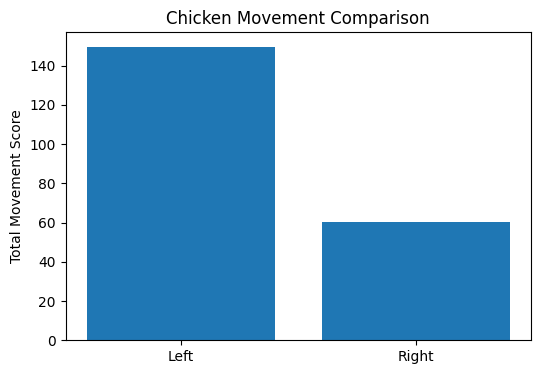

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_LEFT = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hogLeft.mp4"
VIDEO_RIGHT = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hogRight.mp4"

# Movement computation function

def compute_video_movement(video_path):
    cap = cv2.VideoCapture(video_path)

    ret, prev_frame = cap.read()
    if not ret:
        raise ValueError(f"Cannot read video: {video_path}")

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    total_movement = 0
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, gray, None,
            pyr_scale=0.5,
            levels=3,
            winsize=15,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0
        )

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        total_movement += np.mean(mag)
        frame_count += 1

        prev_gray = gray

    cap.release()

    avg_movement = total_movement / max(frame_count, 1)
    return total_movement, avg_movement

# Run analysis
left_total, left_avg = compute_video_movement(VIDEO_LEFT)
right_total, right_avg = compute_video_movement(VIDEO_RIGHT)

# Print results

print("Movement Comparison Results\n")

print(f"Left Video:")
print(f"  Total movement score : {left_total:.4f}")
print(f"  Avg movement/frame   : {left_avg:.6f}\n")

print(f"Right Video:")
print(f"  Total movement score : {right_total:.4f}")
print(f"  Avg movement/frame   : {right_avg:.6f}\n")

# Simple visualization

labels = ["Left", "Right"]
values = [left_total, right_total]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Total Movement Score")
plt.title("Chicken Movement Comparison")
plt.show()

In [ ]:
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict

TRACKS_CSV = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_results_norfair.csv"
VIDEO_PATH = "/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hog2.mp4"

VIDEO_WIDTH_CM = 200

tracks = pd.read_csv(TRACKS_CSV)

def compute_per_chicken_movement(video_path, tracks_df):
    cap = cv2.VideoCapture(video_path)

    ret, prev_frame = cap.read()
    if not ret:
        raise ValueError("Cannot read video")

    video_width_px = prev_frame.shape[1]
    cm_per_pixel = VIDEO_WIDTH_CM / video_width_px

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    movement = defaultdict(lambda: {
        "total": 0.0,
        "frames": 0,
        "max_speed": 0.0
    })

    frame_idx = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, gray, None,
            0.5, 3, 15, 3, 5, 1.2, 0
        )

        frame_tracks = tracks_df[tracks_df["frame"] == frame_idx]

        for _, row in frame_tracks.iterrows():
            cid = int(row["id"])
            x1, y1, x2, y2 = map(int, [row.x1, row.y1, row.x2, row.y2])

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(frame.shape[1], x2)
            y2 = min(frame.shape[0], y2)

            if x2 <= x1 or y2 <= y1:
                continue

            mag, _ = cv2.cartToPolar(
                flow[y1:y2, x1:x2, 0],
                flow[y1:y2, x1:x2, 1]
            )

            mean_motion_px = np.mean(mag)
            mean_motion_cm = mean_motion_px * cm_per_pixel

            movement[cid]["total"] += mean_motion_cm
            movement[cid]["frames"] += 1
            movement[cid]["max_speed"] = max(
                movement[cid]["max_speed"],
                mean_motion_cm
            )

        prev_gray = gray
        frame_idx += 1

    cap.release()
    return movement

movement_per_chicken = compute_per_chicken_movement(VIDEO_PATH, tracks)

print("\nPer-Chicken Movement Results\n")

for cid, data in sorted(movement_per_chicken.items()):
    frames = max(data["frames"], 1)
    avg_movement = data["total"] / frames

    print(f"Chicken ID {cid}")
    print(f"  Total movement : {data['total']:.2f} cm")
    print(f"  Avg / frame    : {avg_movement:.4f} cm/frame")
    print(f"  Max speed      : {data['max_speed']:.4f} cm/frame\n")


Per-Chicken Movement Results

Chicken ID 1
  Total movement : 7.64 cm
  Avg / frame    : 0.0103 cm/frame
  Max speed      : 0.0656 cm/frame

Chicken ID 2
  Total movement : 7.97 cm
  Avg / frame    : 0.0107 cm/frame
  Max speed      : 0.1190 cm/frame

Chicken ID 3
  Total movement : 35.50 cm
  Avg / frame    : 0.0478 cm/frame
  Max speed      : 0.3848 cm/frame

Chicken ID 4
  Total movement : 9.88 cm
  Avg / frame    : 0.0133 cm/frame
  Max speed      : 0.0913 cm/frame

Chicken ID 5
  Total movement : 14.06 cm
  Avg / frame    : 0.0189 cm/frame
  Max speed      : 0.3517 cm/frame

Chicken ID 6
  Total movement : 38.19 cm
  Avg / frame    : 0.0514 cm/frame
  Max speed      : 0.5136 cm/frame

Chicken ID 7
  Total movement : 15.84 cm
  Avg / frame    : 0.0213 cm/frame
  Max speed      : 0.2198 cm/frame

Chicken ID 8
  Total movement : 14.88 cm
  Avg / frame    : 0.0200 cm/frame
  Max speed      : 0.1831 cm/frame

Chicken ID 9
  Total movement : 23.67 cm
  Avg / frame    : 0.0319 cm/frame


# Yolo Ground Truth

In [ ]:
!pip install ultralytics opencv-python numpy tqdm

In [ ]:
#GT with Yolo

import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm
import os

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
MODEL_PATH = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))

OUTPUT_TXT = '/content/chicken_mot_gt.txt'

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter / (areaA + areaB - inter + 1e-6)

class IoUTracker:
    def __init__(self, iou_thresh=0.3, max_lost=10):
        self.iou_thresh = iou_thresh
        self.max_lost = max_lost
        self.tracks = {}
        self.next_id = 1

    def update(self, detections):
        assigned = set()
        results = []

        for tid, track in list(self.tracks.items()):
            best_iou = 0
            best_idx = -1

            for i, det in enumerate(detections):
                if i in assigned:
                    continue
                iou_score = iou(track["bbox"], det["bbox"])
                if iou_score > best_iou:
                    best_iou = iou_score
                    best_idx = i

            if best_iou >= self.iou_thresh:
                det = detections[best_idx]
                self.tracks[tid]["bbox"] = det["bbox"]
                self.tracks[tid]["lost"] = 0
                assigned.add(best_idx)
                results.append((tid, det))
            else:
                self.tracks[tid]["lost"] += 1

            if self.tracks[tid]["lost"] > self.max_lost:
                del self.tracks[tid]

        for i, det in enumerate(detections):
            if i not in assigned:
                tid = self.next_id
                self.next_id += 1
                self.tracks[tid] = {"bbox": det["bbox"], "lost": 0}
                results.append((tid, det))

        return results

model = YOLO(MODEL_PATH)
tracker = IoUTracker(iou_thresh=0.3, max_lost=15)

cap = cv2.VideoCapture(VIDEO_PATH)
frame_id = 1

mot_lines = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(frame, conf=0.7, verbose=False)[0]

    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        score = float(box.conf[0])
        cls = int(box.cls[0])

        detections.append({
            "bbox": [x1, y1, x2, y2],
            "score": score,
            "class": cls
        })

    tracks = tracker.update(detections)

    for tid, det in tracks:
        x1, y1, x2, y2 = det["bbox"]
        w = x2 - x1
        h = y2 - y1

        visibility = 1.0
        line = [
            frame_id,
            tid,
            int(x1),
            int(y1),
            int(w),
            int(h),
            round(det["score"], 4),
            det["class"],
            round(visibility, 2)
        ]
        mot_lines.append(",".join(map(str, line)))

    frame_id += 1

cap.release()

with open(OUTPUT_TXT, "w") as f:
    f.write("\n".join(mot_lines))

print("MOT ground truth saved to:", OUTPUT_TXT)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
MOT ground truth saved to: /content/chicken_mot_gt.txt


# Comparison Metrics (MOT)

In [ ]:
!pip install numpy==1.26.4 motmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
#Comparison metrics

import motmetrics as mm

GT_TXT = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/chicken_mot_gt.txt'

TRACKERS = {
    'Norfair': '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/norfair_hog.txt',
    'BoT-SORT': '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/botsort.txt',
    'ByteTrack': '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/bytetrack.txt',
    'DeepSORT': '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/deepsort.txt',
    'AutoEncoder': '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/MOT/auto_encoder.txt',
}

# Load ground truth and tracker output
gt = mm.io.loadtxt(GT_TXT, fmt='mot16')

accs = []
names = []

# Create an accumulator for each tracker
for tracker_name, tracker_path in TRACKERS.items():
    ts = mm.io.loadtxt(tracker_path, fmt='mot16')

    acc = mm.utils.compare_to_groundtruth(
        gt,
        ts,
        dist='iou',
        distth=0.5
    )

    accs.append(acc)
    names.append(tracker_name)

# Metrics handler
mh = mm.metrics.create()

metrics = [
    'mota',
    'motp',
    'idf1',
    'num_switches',
    'num_false_positives',
    'num_misses'
]

# Compute metrics for all trackers
summary = mh.compute_many(
    accs,
    metrics=metrics,
    names=names,
    generate_overall=False
)

# Display formatting
summary = mm.io.render_summary(
    summary,
    formatters=mh.formatters,
    namemap={
        'mota': 'MOTA',
        'motp': 'MOTP',
        'idf1': 'IDF1',
        'num_switches': 'Switches',
        'num_false_positives': 'FP',
        'num_misses': 'FN'
    }
)

print(summary)

             MOTA  MOTP  IDF1 Switches  FP  FN
Norfair     94.6% 0.015 96.1%        5 130 309
BoT-SORT    99.7% 0.020 96.8%       11   0  13
ByteTrack   99.7% 0.036 97.3%       10   2  15
DeepSORT    93.4% 0.117 92.6%       11 439  87
AutoEncoder 94.6% 0.015 96.1%        5 129 308


# Auto-Encoder

In [ ]:
!pip install -U numpy>=2.0
!pip install -U ultralytics norfair opencv-python

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-

In [ ]:
#Auto-encoder try

import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from norfair import Detection, Tracker, draw_tracked_objects
from ultralytics import YOLO
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_autoencoder.mp4'
WEIGHTS_PATH = '/content/chicken_autoencoder.pth'
YOLO_WEIGHTS = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/runs/segment/train/weights/best.pt'

#Auto-Encoder Model
class ChickenAutoEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()


        self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, 4, 2, 1),
          nn.ReLU(),
          nn.Conv2d(32, 64, 4, 2, 1),
          nn.ReLU(),
          nn.Conv2d(64, 128, 4, 2, 1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(128 * 16 * 8, embedding_dim)
        )


        self.decoder = nn.Sequential(
          nn.Linear(embedding_dim, 128 * 16 * 8),
          nn.Unflatten(1, (128, 16, 8)),
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 3, 4, 2, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

#Extract Chicken Crops for Training
model = YOLO(YOLO_WEIGHTS)

crops = []
for result in model.predict(VIDEO_PATH, stream=True, conf=0.7):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()

    for x, y, w, h in boxes:
        x, y, w, h = map(int, [x, y, w, h])
        x1, y1 = max(0, x-w//2), max(0, y-h//2)
        x2, y2 = x+w//2, y+h//2
        crop = frame[y1:y2, x1:x2]
        if crop.size > 0:
            crops.append(crop)

print("Total crops:", len(crops))

#Dataset & DataLoader
class ChickenCropDataset(Dataset):
    def __init__(self, crops):
        self.crops = crops

    def __len__(self):
        return len(self.crops)

    def __getitem__(self, idx):
        img = cv2.resize(self.crops[idx], (64, 128))
        img = img.astype(np.float32) / 255.0
        return torch.from_numpy(img).permute(2, 0, 1)

dataset = ChickenCropDataset(crops)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

#Train Auto-Encoder
model_ae = ChickenAutoEncoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(15):
    loss_sum = 0
    for imgs in dataloader:
        imgs = imgs.to(device)
        recon, _ = model_ae(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    print(f"Epoch {epoch+1}: {loss_sum/len(dataloader):.4f}")

torch.save(model_ae.state_dict(), WEIGHTS_PATH)

#Embedding Function
model_ae.eval()

def get_embedding(crop):
    crop = cv2.resize(crop, (64, 128))
    crop = crop.astype(np.float32) / 255.0
    crop = torch.from_numpy(crop).permute(2,0,1).unsqueeze(0).to(device)

    with torch.no_grad():
        _, emb = model_ae(crop)

    return emb.cpu().numpy().flatten()

#Norfair Distance Function
def ae_distance(detection, tracked_object):
    pos_dist = np.linalg.norm(detection.points[0] - tracked_object.estimate[0])
    emb_dist = np.linalg.norm(detection.embedding - tracked_object.last_detection.embedding)
    return 0.3 * pos_dist + 0.7 * emb_dist

#Tracking & Video Output
tracker = Tracker(distance_function=ae_distance, distance_threshold=50)
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

for result in model.predict(VIDEO_PATH, stream=True, conf=0.7):
    frame = result.orig_img
    detections = []

    for x, y, w0, h0 in result.boxes.xywh.cpu().numpy():
        x, y, w0, h0 = map(int, [x, y, w0, h0])
        crop = frame[max(0,y-h0//2):y+h0//2, max(0,x-w0//2):x+w0//2]
        if crop.size == 0:
            continue

        emb = get_embedding(crop)
        detections.append(Detection(points=np.array([[x,y]]), scores=np.array([1.0]), embedding=emb))

    tracked = tracker.update(detections)
    draw_tracked_objects(frame, tracked)
    out.write(frame)

cap.release()
out.release()
print("Saved to:", OUTPUT_PATH)

Using device: cpu

video 1/1 (frame 1/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 636.6ms
video 1/1 (frame 2/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 290.0ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 284.4ms
video 1/1 (frame 4/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 286.0ms
video 1/1 (frame 5/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 281.7ms
video 1/1 (frame 6/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 286.7ms
video 1/1 (frame 7/750) /content/gdrive/My Drive/ComputerVisionEngineer/Obj

Epoch 15: 0.0017

video 1/1 (frame 1/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 554.5ms


video 1/1 (frame 2/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 304.6ms
video 1/1 (frame 3/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 282.2ms
video 1/1 (frame 4/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 281.8ms
video 1/1 (frame 5/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 272.0ms
video 1/1 (frame 6/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 273.5ms
video 1/1 (frame 7/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_30s.mp4: 480x800 32 Chickens, 271.8ms
video 1/1 (frame 8/750) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8G

In [ ]:
#Auto-encoder try for comparison (MOT)

import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from norfair import Detection, Tracker, draw_tracked_objects
from ultralytics import YOLO
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_autoencoder.mp4'
WEIGHTS_PATH = '/content/chicken_autoencoder.pth'
YOLO_WEIGHTS = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/runs/segment/train/weights/best.pt'

#Auto-Encoder Model
class ChickenAutoEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()


        self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, 4, 2, 1),
          nn.ReLU(),
          nn.Conv2d(32, 64, 4, 2, 1),
          nn.ReLU(),
          nn.Conv2d(64, 128, 4, 2, 1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(128 * 16 * 8, embedding_dim)
        )


        self.decoder = nn.Sequential(
          nn.Linear(embedding_dim, 128 * 16 * 8),
          nn.Unflatten(1, (128, 16, 8)),
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, 4, 2, 1),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 3, 4, 2, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

#Extract Chicken Crops for Training
model = YOLO(YOLO_WEIGHTS)

crops = []
for result in model.predict(VIDEO_PATH, stream=True, conf=0.7):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()

    for x, y, w, h in boxes:
        x, y, w, h = map(int, [x, y, w, h])
        x1, y1 = max(0, x-w//2), max(0, y-h//2)
        x2, y2 = x+w//2, y+h//2
        crop = frame[y1:y2, x1:x2]
        if crop.size > 0:
            crops.append(crop)

print("Total crops:", len(crops))

#Dataset & DataLoader
class ChickenCropDataset(Dataset):
    def __init__(self, crops):
        self.crops = crops

    def __len__(self):
        return len(self.crops)

    def __getitem__(self, idx):
        img = cv2.resize(self.crops[idx], (64, 128))
        img = img.astype(np.float32) / 255.0
        return torch.from_numpy(img).permute(2, 0, 1)

dataset = ChickenCropDataset(crops)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

#Train Auto-Encoder
model_ae = ChickenAutoEncoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(15):
    loss_sum = 0
    for imgs in dataloader:
        imgs = imgs.to(device)
        recon, _ = model_ae(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    print(f"Epoch {epoch+1}: {loss_sum/len(dataloader):.4f}")

torch.save(model_ae.state_dict(), WEIGHTS_PATH)

#Embedding Function
model_ae.eval()

def get_embedding(crop):
    crop = cv2.resize(crop, (64, 128))
    crop = crop.astype(np.float32) / 255.0
    crop = torch.from_numpy(crop).permute(2,0,1).unsqueeze(0).to(device)

    with torch.no_grad():
        _, emb = model_ae(crop)

    return emb.cpu().numpy().flatten()

#Norfair Distance Function
def ae_distance(detection, tracked_object):
    pos_dist = np.linalg.norm(detection.points[0] - tracked_object.estimate[0])
    emb_dist = np.linalg.norm(detection.embedding - tracked_object.last_detection.embedding)
    return 0.3 * pos_dist + 0.7 * emb_dist

#Tracking & Video Output
tracker = Tracker(distance_function=ae_distance, distance_threshold=50)
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

mot_results = []
frame_id = 1

for result in model.predict(VIDEO_PATH, stream=True, conf=0.7):
    frame = result.orig_img
    detections = []

    boxes = result.boxes.xywh.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()

    for (x, y, w, h), conf in zip(boxes, confs):
        x, y, w, h = map(int, [x, y, w, h])

        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(width,  x + w // 2)
        y2 = min(height, y + h // 2)

        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        emb = get_embedding(crop)

        detections.append(
            Detection(
                points=np.array([[x, y]]),
                scores=np.array([conf]),
                embedding=emb,
                data={"w": w, "h": h}
            )
        )

    tracked_objects = tracker.update(detections)

    for obj in tracked_objects:
        if obj.last_detection is None:
            continue

        x, y = obj.estimate[0]
        w = obj.last_detection.data["w"]
        h = obj.last_detection.data["h"]

        x1 = int(x - w / 2)
        y1 = int(y - h / 2)

        mot_results.append(
            f"{frame_id},{obj.id},{x1},{y1},{w},{h},1,-1,-1\n"
        )

    draw_tracked_objects(frame, tracked_objects)
    out.write(frame)

    frame_id += 1

with open("auto_encoder.txt", "w") as f:
    f.writelines(mot_results)
cap.release()
out.release()
print("Saved to:", OUTPUT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cpu

video 1/1 (frame 1/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 527.0ms
video 1/1 (frame 2/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 279.5ms
video 1/1 (frame 3/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 264.0ms
video 1/1 (frame 4/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 263.4ms
video 1/1 (frame 5/250) /content/gdrive/My Drive/ComputerVisionEng

Epoch 15: 0.0019

video 1/1 (frame 1/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 273.0ms


video 1/1 (frame 2/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 251.9ms
video 1/1 (frame 3/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 264.2ms
video 1/1 (frame 4/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 259.1ms
video 1/1 (frame 5/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 248.7ms
video 1/1 (frame 6/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 262.3ms
video 1/1 (frame 7/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/trimmed_10s.mp4: 480x800 32 Chickens, 303.3ms
video 1/1 (frame 8/250) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8G

# Drawing Path

In [ ]:
!pip install norfair[video] opencv-python-headless==4.8.0.74

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
Reason for being yanked: deprecated, use 4.8.0.76
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=29ca8fd42d85ee32d966394c563dc3851a6643d3f33e63a699f6930503752e72
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built fil

In [ ]:
#Drawing path with Norfair + HoG

import cv2
import torch
import numpy as np
from norfair import Detection, Tracker, Video, draw_tracked_objects
from ultralytics import YOLO
import os
from collections import defaultdict

VIDEO_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4'
OUTPUT_PATH = '/content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/chicken_tracking_output_hog_DrawPath.mp4'

TARGET_ID = 22
track_history = defaultdict(list)

hog = cv2.HOGDescriptor(
    _winSize=(64, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9,
)

def hog_distance(detection, tracked_object):
    det_center = detection.points[0]
    track_center = tracked_object.estimate[0]
    pos_dist = np.linalg.norm(det_center - track_center)

    det_hog = detection.embedding
    track_hog = tracked_object.last_detection.embedding
    hog_dist = np.linalg.norm(det_hog - track_hog)

    return pos_dist * 0.3 + hog_dist * 0.7

model = YOLO(os.path.join(ROOT_DIR, "runs/segment/train/weights/best.pt"))
results = model.predict(VIDEO_PATH, stream=True)

tracker = Tracker(distance_function=hog_distance, distance_threshold=30)

# Prepare video reader/writer
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

# Process frames one by one
frame_idx = 0
for result in model.predict(VIDEO_PATH, stream=True):
    frame = result.orig_img
    boxes = result.boxes.xywh.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy().astype(int)

    # Filter detections by confidence
    CONF_THRESH = 0.7
    mask = confs >= CONF_THRESH
    boxes, confs, classes = boxes[mask], confs[mask], classes[mask]

    TARGET_CLASSES = []
    if TARGET_CLASSES:
        class_mask = np.isin(classes, TARGET_CLASSES)
        boxes, confs = boxes[class_mask], confs[class_mask]

    # Convert detections to Norfair format
    detections = []
    for b, c in zip(boxes, confs):
        x, y, w, h = map(int, b)

        x1 = max(x - w//2, 0)
        y1 = max(y - h//2, 0)
        x2 = min(x + w//2, width)
        y2 = min(y + h//2, height)
        crop = frame[y1:y2, x1:x2]

        crop_resized = cv2.resize(crop, (64, 128))
        hog_feat = hog.compute(crop_resized).reshape(-1)

        detections.append(
            Detection(
                points=np.array([[x, y]]),
                scores=np.array([c]),
                embedding=hog_feat
            )
        )

    # Update tracker
    tracked_objects = tracker.update(detections=detections)

    # Draw tracked objects on the frame
    draw_tracked_objects(frame, tracked_objects)

    # Draw trajectory for one chicken
    for obj in tracked_objects:
        if obj.id == TARGET_ID:
            # Current center point
            cx, cy = obj.estimate[0].astype(int)

            # Save history
            track_history[TARGET_ID].append((cx, cy))

            # Draw path
            for i in range(1, len(track_history[TARGET_ID])):
                cv2.line(
                    frame,
                    track_history[TARGET_ID][i - 1],
                    track_history[TARGET_ID][i],
                    color=(0, 0, 255),
                    thickness=2
                )

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"Tracking complete! Saved to: {OUTPUT_PATH}")


video 1/1 (frame 1/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 496.1ms
video 1/1 (frame 2/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 425.4ms
video 1/1 (frame 3/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 514.5ms
video 1/1 (frame 4/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 381.6ms
video 1/1 (frame 5/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 882.4ms
video 1/1 (frame 6/3000) /content/gdrive/My Drive/ComputerVisionEngineer/ObjectDetectionYolov8GoogleColab/shortened_video.mp4: 480x800 35 Chickens, 412.5ms
video 1/1 (frame 7/3000) /content/gdrive/My Drive/ComputerVisio